# Theoretical Modelling Analysis
This script will be used to generate plots for my thesis, in particular I'll generate each of the plots i need for the theoretical modelling analysis. This should be versatile enough to work for the ZFOURGE observational (semi-empirical) models, and the pure theoretical models.

In [200]:
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
import pandas as pd
import os
from astLib import astSED
import astropy.io.fits as fits
from carf import * # custom module for functions relating to the project
import matplotlib.path as mpath


# So that we can change the helper functions without reloading the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [201]:
# Choose if you want to save the plots
save_figures = False

In [202]:
# We would like to investigate the effects of the different filters.
# Read in the dataframe

template_set_name = 'Brown'
agn_model_name = 'Type2AGN'

composite_choice = f'{template_set_name}_theoretical_composite_fluxes_{agn_model_name}'

# read in the dataframe and ensure that the unamed: 0 column is the index
composite_choice = f'{template_set_name}_theoretical_composite_fluxes_{agn_model_name}'
composite_fluxes = pd.read_csv(f'outputs\composite_seds\{composite_choice}.csv', index_col=0)   
# Drop the first col
#composite_fluxes = composite_fluxes.drop(columns=['Unnamed: 0.1'])

In [203]:
# Check outputs
composite_fluxes

,id,z,U_0,U_10,U_20,U_30,U_40,U_50,U_60,U_70,...,r_10,r_20,r_30,r_40,r_50,r_60,r_70,r_80,r_90,r_100
0,Arp_118,0.0,-21.198908,-21.198975,-21.199042,-21.199109,-21.199176,-21.199243,-21.199310,-21.199377,...,-23.434047,-23.434078,-23.434109,-23.434140,-23.434171,-23.434202,-23.434233,-23.434264,-23.434295,-23.434326
1,Arp_256_N,0.0,-20.237172,-20.237200,-20.237228,-20.237256,-20.237284,-20.237312,-20.237340,-20.237368,...,-21.470688,-21.470720,-21.470753,-21.470786,-21.470818,-21.470851,-21.470884,-21.470917,-21.470949,-21.470982
2,Arp_256_S,0.0,-20.201401,-20.201459,-20.201517,-20.201574,-20.201632,-20.201690,-20.201747,-20.201805,...,-21.415551,-21.415620,-21.415688,-21.415757,-21.415825,-21.415894,-21.415962,-21.416031,-21.416099,-21.416167
3,CGCG_049-057,0.0,-17.401194,-17.401350,-17.401506,-17.401662,-17.401818,-17.401974,-17.402130,-17.402286,...,-19.862438,-19.862497,-19.862555,-19.862614,-19.862673,-19.862731,-19.862790,-19.862849,-19.862907,-19.862966
4,CGCG_436-030,0.0,-20.094718,-20.094805,-20.094892,-20.094979,-20.095066,-20.095153,-20.095240,-20.095327,...,-21.488948,-21.489035,-21.489123,-21.489210,-21.489298,-21.489385,-21.489473,-21.489560,-21.489647,-21.489735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,UGC_09618_N,3.9,37.371478,37.095493,36.875635,36.692888,36.536515,36.399853,36.278486,36.169333,...,29.222563,29.222281,29.221999,29.221717,29.221435,29.221153,29.220872,29.220590,29.220308,29.220027
124,UGC_09618,3.9,36.333443,36.175846,36.038252,35.916150,35.806402,35.706737,35.615456,35.531257,...,27.884020,27.883905,27.883789,27.883674,27.883558,27.883443,27.883328,27.883212,27.883097,27.882981
125,UGC_09618_S,3.9,34.982780,34.967244,34.951927,34.936823,34.921927,34.907232,34.892733,34.878426,...,27.933748,27.933709,27.933670,27.933632,27.933593,27.933554,27.933516,27.933477,27.933438,27.933400
126,UGC_12150,3.9,38.434321,38.111938,37.863686,37.661767,37.491576,37.344482,37.214960,37.099255,...,31.658945,31.657752,31.656559,31.655368,31.654178,31.652990,31.651803,31.650617,31.649432,31.648249


In [204]:
# Check which IRAC filters are available (whatever begins with IRAC)
irac_filters = [col for col in composite_fluxes.columns if col.startswith('IRAC')]
print(irac_filters)


['IRAC3.6_0', 'IRAC3.6_10', 'IRAC3.6_20', 'IRAC3.6_30', 'IRAC3.6_40', 'IRAC3.6_50', 'IRAC3.6_60', 'IRAC3.6_70', 'IRAC3.6_80', 'IRAC3.6_90', 'IRAC3.6_100', 'IRAC4.5_0', 'IRAC4.5_10', 'IRAC4.5_20', 'IRAC4.5_30', 'IRAC4.5_40', 'IRAC4.5_50', 'IRAC4.5_60', 'IRAC4.5_70', 'IRAC4.5_80', 'IRAC4.5_90', 'IRAC4.5_100', 'IRAC5.8_0', 'IRAC5.8_10', 'IRAC5.8_20', 'IRAC5.8_30', 'IRAC5.8_40', 'IRAC5.8_50', 'IRAC5.8_60', 'IRAC5.8_70', 'IRAC5.8_80', 'IRAC5.8_90', 'IRAC5.8_100', 'IRAC8.0_0', 'IRAC8.0_10', 'IRAC8.0_20', 'IRAC8.0_30', 'IRAC8.0_40', 'IRAC8.0_50', 'IRAC8.0_60', 'IRAC8.0_70', 'IRAC8.0_80', 'IRAC8.0_90', 'IRAC8.0_100']


In [205]:
# Check for each entry of a particular filter, how many variations of it there are i.e U_0, U_10
# Allow us to have a robust way of investigating the effects of the different alpha values automatically, without recoding the filter names/alpha values

# Get the filters
filters = composite_fluxes.columns[2:]

# For the first filter, see how many variations there are
filter_choice = filters[0].split('_')[0]


# Get the variations
filter_variations = [filter for filter in filters if filter_choice in filter]

# add the alpha values to a new array
alpha_values = [int(filter.split('_')[1]) for filter in filter_variations]

# Print the alpha values
print(alpha_values)


[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


## UVJ
### Plot
The code below will generate a subplot for the UVJ diagrams of the theoretical models. 

C:\Users\Titan\AppData\Local\Temp\ipykernel_14344\1379401099.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[2, 3].scatter(vj, uv, c=colours_theme[m], s=10)


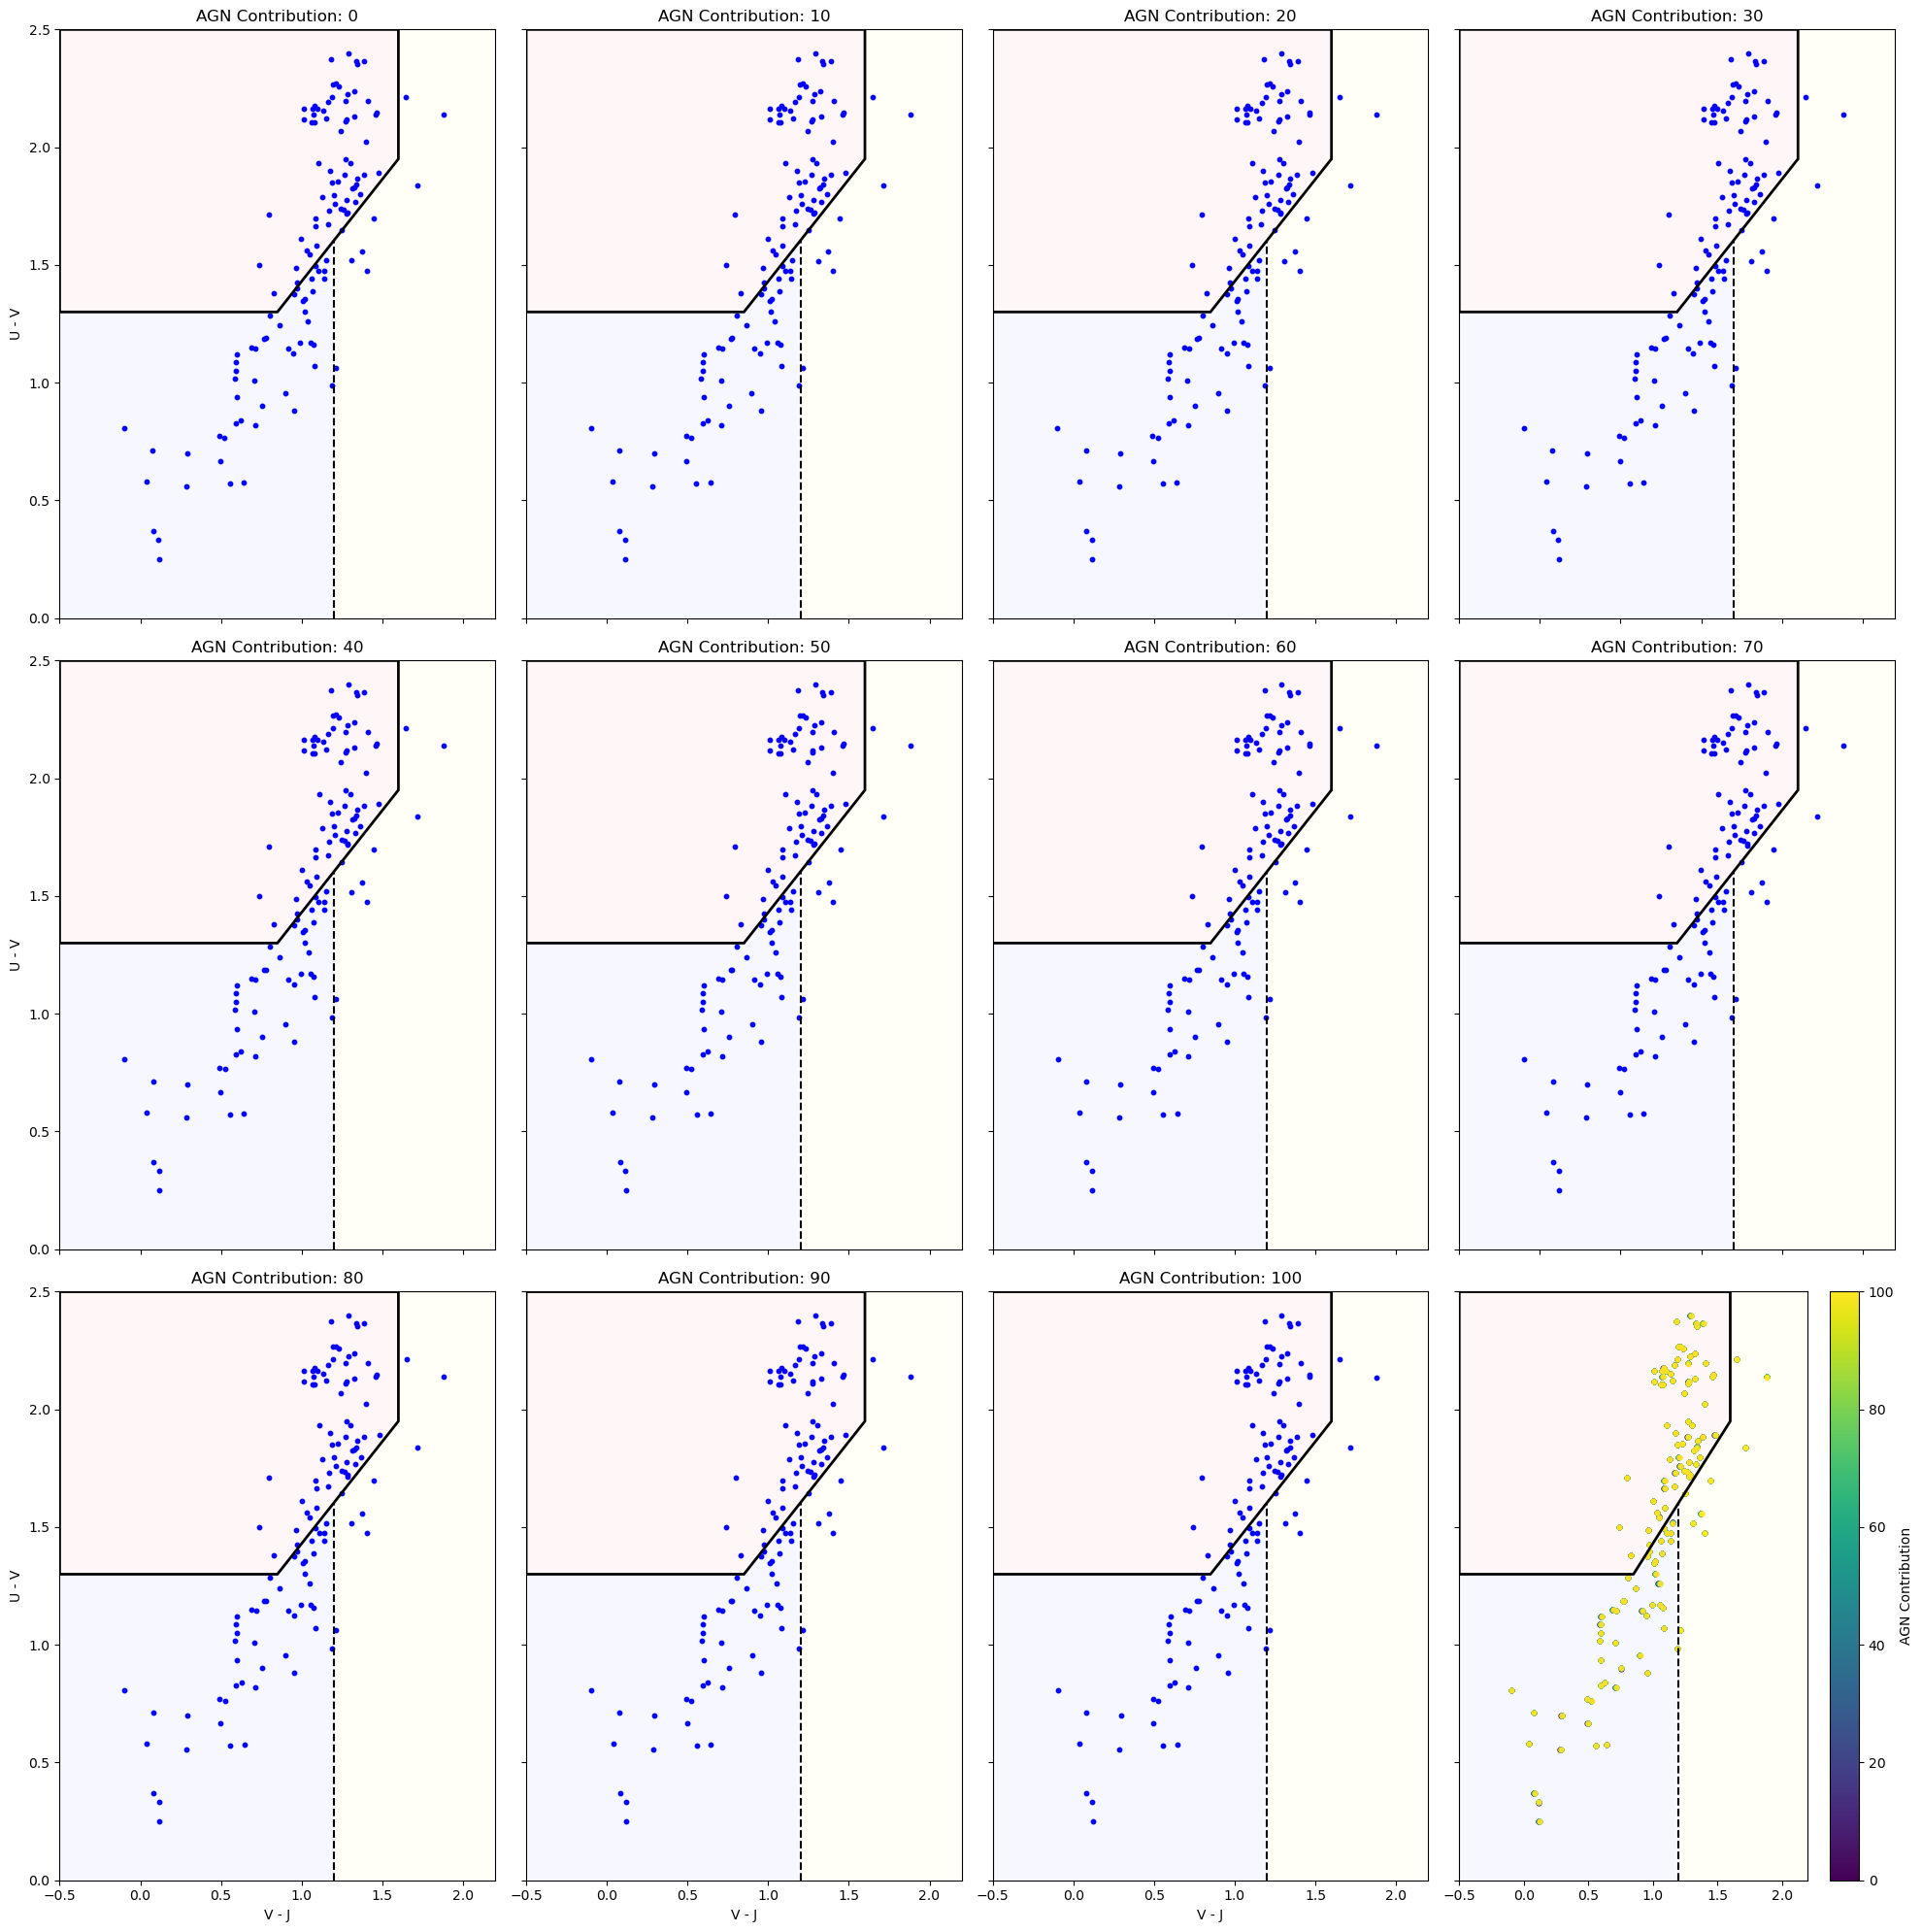

In [206]:
spacing = len(alpha_values)
colours_theme = plt.cm.viridis(np.linspace(0, 1, spacing))



fig, axs = plt.subplots(3, 4, figsize=(20, 20), sharex=True, sharey=True)
for n in range(len(alpha_values)):
    # Get the filter magnitudes
    U_mag = composite_fluxes[f'U_{alpha_values[n]}']
    V_mag = composite_fluxes[f'V_{alpha_values[n]}']
    J_mag = composite_fluxes[f'J_{alpha_values[n]}']
    
    # Create the colours
    uv = U_mag - V_mag
    vj = V_mag - J_mag
    
    # Recall that this is only a restframe diagram, so only look at the restframe colours
    uv = uv[composite_fluxes['z'] == 0]
    vj = vj[composite_fluxes['z'] == 0]
    
    axs[n//4, n%4].scatter(vj, uv, c='blue', s=10)
    
    axs[n//4, n%4].set_xlim(-0.5, 2.2)
    axs[n//4, n%4].set_ylim(0, 2.5)
    
    # Plot AGN Contribution in the title
    axs[n//4, n%4].set_title(f'AGN Contribution: {alpha_values[n]}')
    
    # Define paths for selections
    path_quiescent = [[-0.5, 1.3], [0.85, 1.3], [1.6, 1.95], [1.6, 2.5], [-0.5, 2.5]]
    path_sf = [[-0.5, 0.0], [-0.5, 1.3], [0.85, 1.3], [1.2, 1.60333], [1.2, 0.0]]
    path_sfd = [[1.2, 0.0], [1.2, 1.60333], [1.6, 1.95], [1.6, 2.5], [2.2, 2.5], [2.2, 0.0]]
    
    # Add patches for selections
    axs[n//4, n%4].add_patch(plt.Polygon(path_quiescent, closed=True, fill=True, facecolor=(1, 0, 0, 0.03), edgecolor='k', linewidth=2, linestyle='solid'))
    axs[n//4, n%4].add_patch(plt.Polygon(path_sf, closed=True, fill=True, facecolor=(0, 0, 1, 0.03)))
    axs[n//4, n%4].add_patch(plt.Polygon(path_sfd, closed=True, fill=True, facecolor=(1, 1, 0, 0.03)))
    
    # Add vertical line
    axs[n//4, n%4].axvline(1.2, color='black', linestyle='--', ymin=0, ymax=1.60333/2.5)
    
    # Add axis labels
    if n//4 == 2:
        axs[n//4, n%4].set_xlabel("V - J")
    if n%4 == 0:
        axs[n//4, n%4].set_ylabel("U - V")

for m in range(len(alpha_values)):
    # Get the filter magnitudes
    U_mag = composite_fluxes[f'U_{alpha_values[m]}']
    V_mag = composite_fluxes[f'V_{alpha_values[m]}']
    J_mag = composite_fluxes[f'J_{alpha_values[m]}']
    
    # Create the colours
    uv = U_mag - V_mag
    vj = V_mag - J_mag
    
    # Recall that this is only a restframe diagram, so only look at the restframe colours
    uv = uv[composite_fluxes['z'] == 0]
    vj = vj[composite_fluxes['z'] == 0]
    
    # Plot scatter
    axs[2, 3].scatter(vj, uv, c=colours_theme[m], s=10)
    
    
# Add patches for selections
axs[2, 3].add_patch(plt.Polygon(path_quiescent, closed=True, fill=True, facecolor=(1, 0, 0, 0.03), edgecolor='k', linewidth=2, linestyle='solid'))
axs[2, 3].add_patch(plt.Polygon(path_sf, closed=True, fill=True, facecolor=(0, 0, 1, 0.03)))
axs[2, 3].add_patch(plt.Polygon(path_sfd, closed=True, fill=True, facecolor=(1, 1, 0, 0.03)))

# Add vertical line
axs[2, 3].axvline(1.2, color='black', linestyle='--', ymin=0, ymax=1.60333/2.5)

# Plot colorbar for AGN contribution
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(alpha_values), vmax=max(alpha_values)))
cbar = plt.colorbar(sm, ax=axs[2, 3])

# Name the colorbar
cbar.set_label('AGN Contribution')

    
    

plt.tight_layout()    

# Save the output
if save_figures:
    plt.savefig(f'outputs/UVJPlots/UVJ_evolution_{agn_model_name}_{template_set_name}.png')

# Show the output
plt.show()


### Metrics
These will be used to analyze the results from the UVJ diagram above

## ugr
### Plot

C:\Users\Titan\AppData\Local\Temp\ipykernel_14344\204720021.py:60: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[2, 3].scatter(gr_specific_alpha_colours,


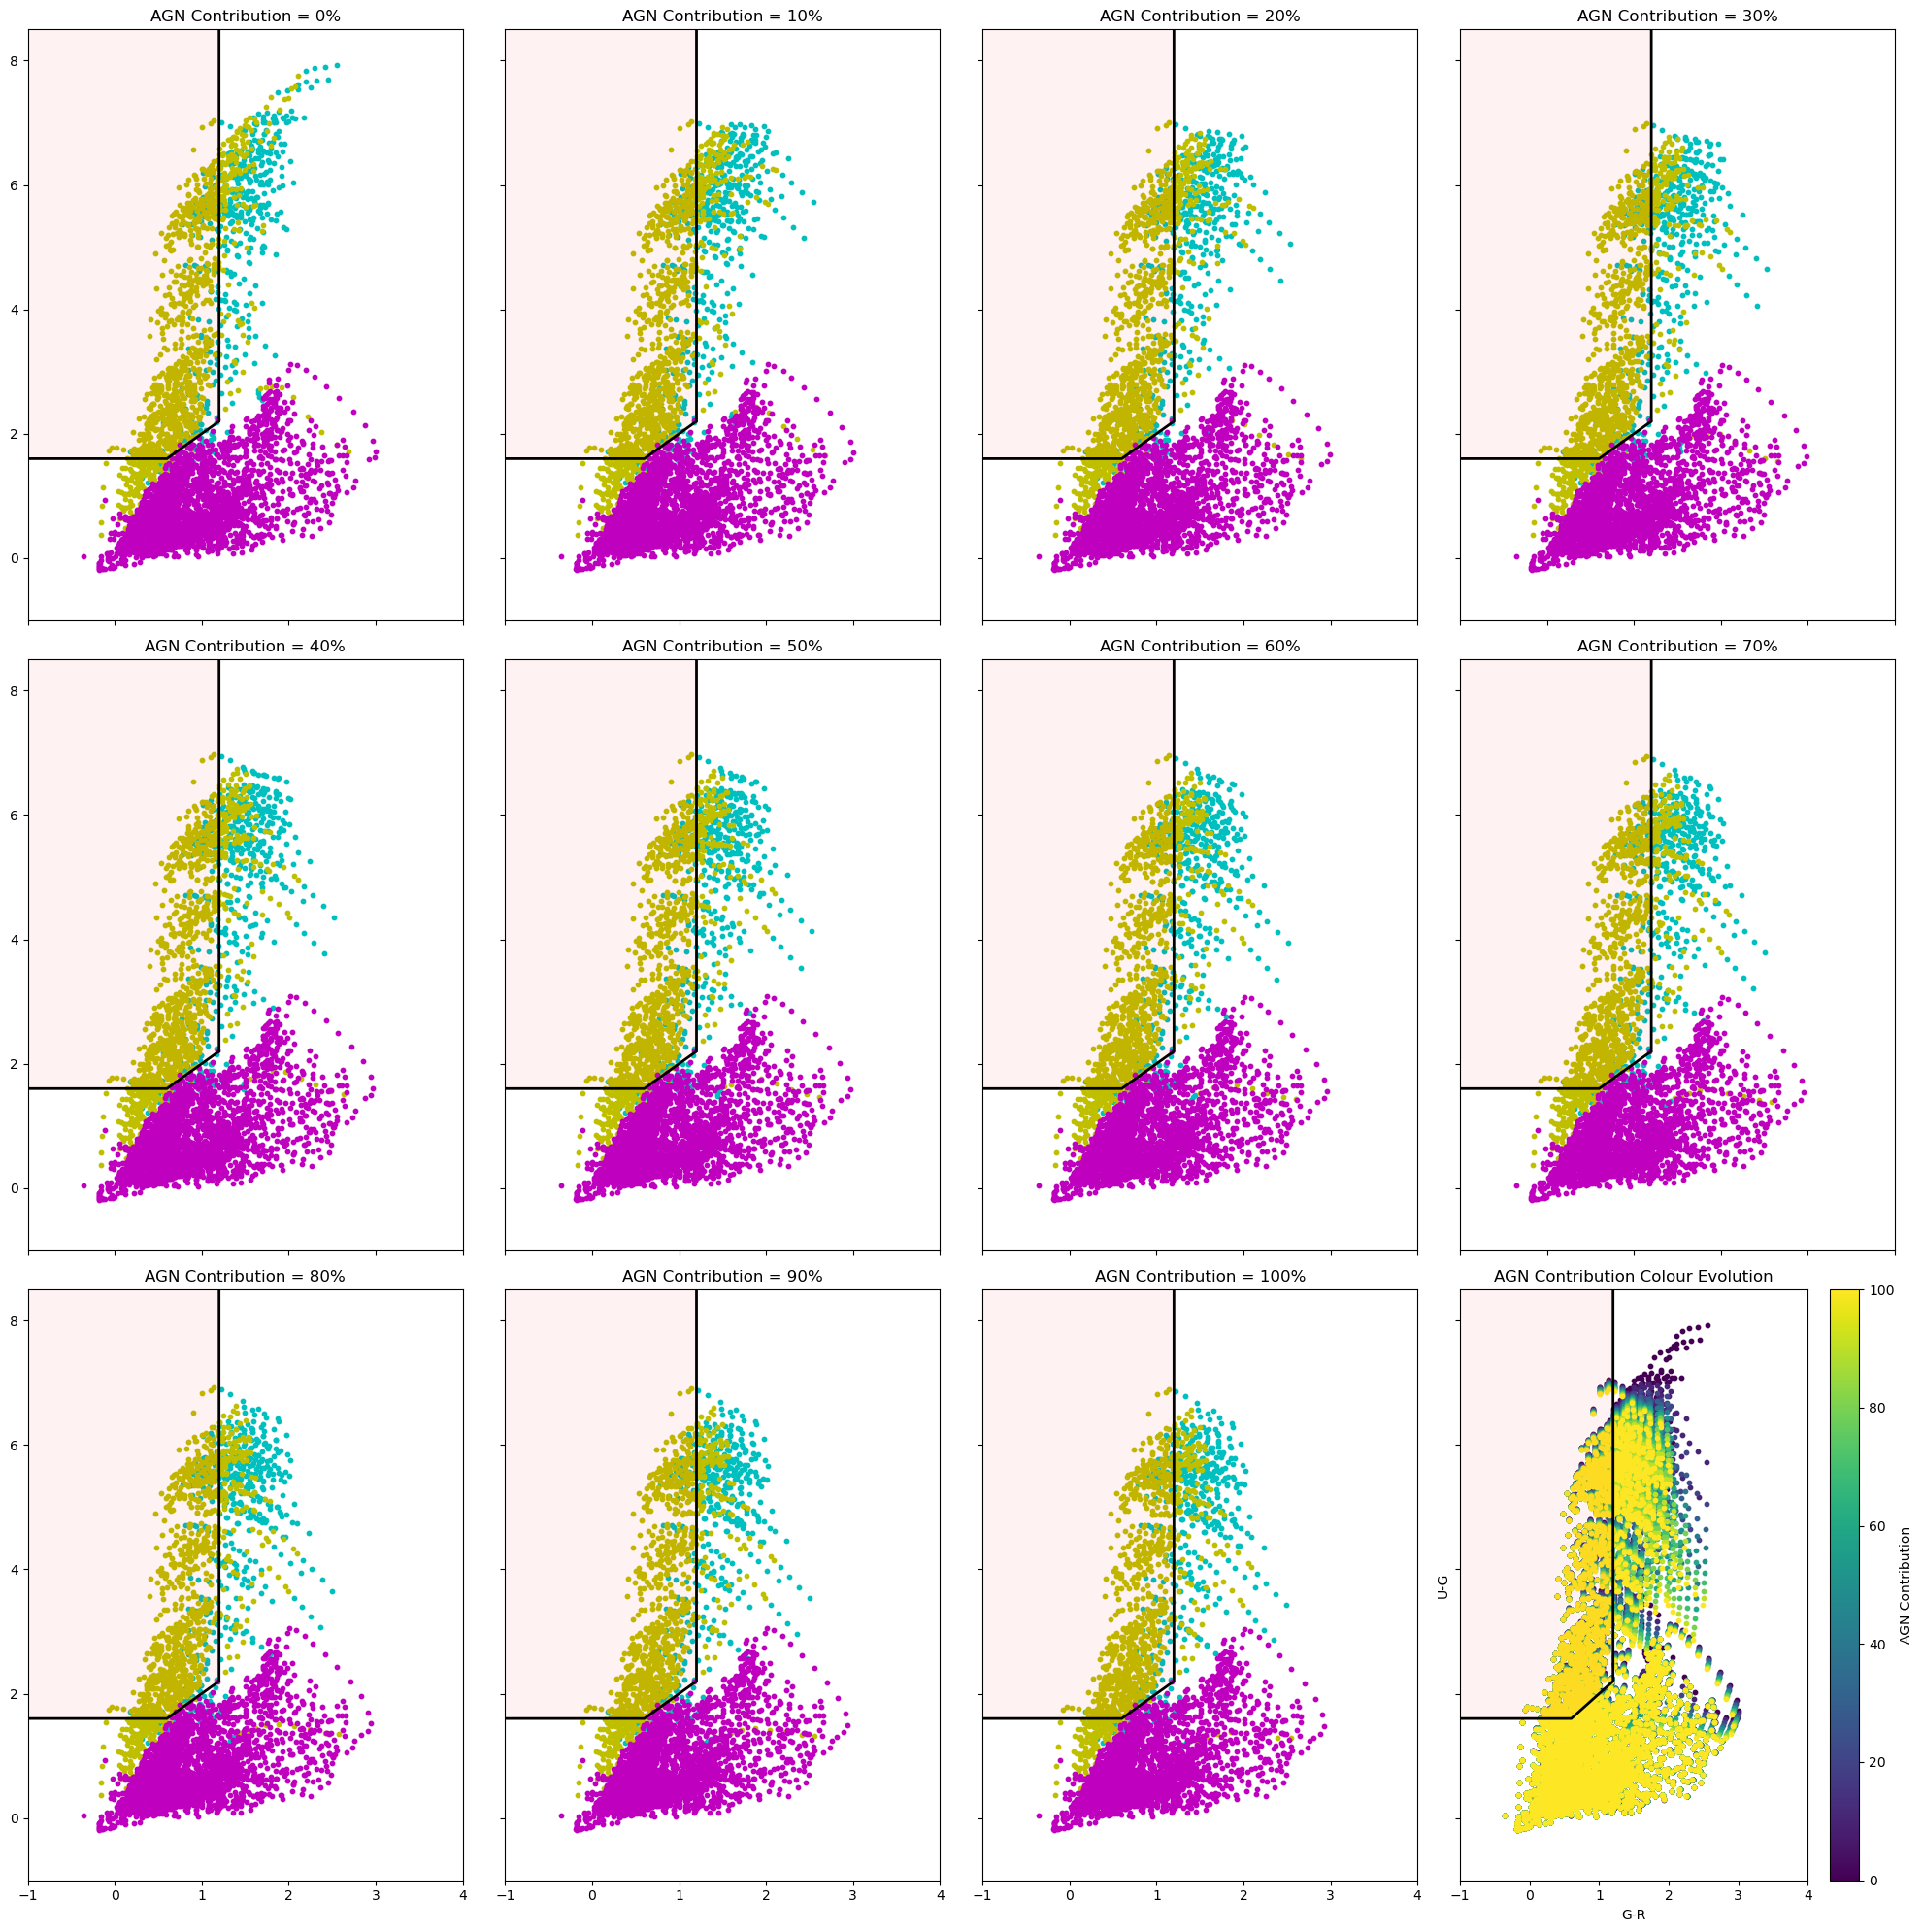

In [220]:

# ugr Diagram 
fig, axs = plt.subplots(3, 4, figsize=(20, 20), sharex=True, sharey=True)
for n in range(len(alpha_values)):
    # Get the u, g, and r magnitudes for the specific alpha value
    u_col_name = f'u_{int(round(alpha_values[n], 2))}'
    g_col_name = f'g_{int(round(alpha_values[n], 2))}'
    r_col_name = f'r_{int(round(alpha_values[n], 2))}'
    
    # Create the colours for the UGR diagram
    ug_specific_alpha_colours = composite_fluxes[u_col_name] - composite_fluxes[g_col_name]
    gr_specific_alpha_colours = composite_fluxes[g_col_name] - composite_fluxes[r_col_name]

    # Scatter plots with color-coded redshift ranges
    axs[n // 4, n % 4].scatter(gr_specific_alpha_colours[composite_fluxes['z'] > 3.5], 
                               ug_specific_alpha_colours[composite_fluxes['z'] > 3.5], 
                               c="c", s=10, label="z > 3.5")

    axs[n // 4, n % 4].scatter(gr_specific_alpha_colours[(composite_fluxes['z'] > 2.6) & (composite_fluxes['z'] <= 3.5)], 
                               ug_specific_alpha_colours[(composite_fluxes['z'] > 2.6) & (composite_fluxes['z'] <= 3.5)], 
                               c="y", s=10, label="2.6 < z < 3.5")

    axs[n // 4, n % 4].scatter(gr_specific_alpha_colours[composite_fluxes['z'] < 2.6], 
                               ug_specific_alpha_colours[composite_fluxes['z'] < 2.6], 
                               c="m", s=10, label="z < 2.6")
    
    
    # Set the AGN Contribution title 
    axs[n//4, n%4].set_title(f"AGN Contribution = {round(alpha_values[n], 1)}%")
    
    plt.xlabel("G-R")
    plt.ylabel("U-G")
    #plt.title("UGR Diagram for SED Templates at Different Redshifts(0 < z < 4) for alpha = {}".format(alphas[n]))

    
    
    # add the alpha value information onto the plot somewhere
    #axs[n//4, n%4].text(0.5, 0.9, f"alpha = {round(alpha[n], 2)}", horizontalalignment='center', verticalalignment='center', transform=axs[n//4, n%4].transAxes)

    # Additionally we can plot the UGR selection criteria on the UGR diagram
    U_rule = [[1.2,9], [1.2,2.2], [0.6,1.6], [-3,1.6], [-3,9]]
    axs[n//4, n%4].add_patch(plt.Polygon(U_rule, closed=True, fill=True, facecolor=(1,0,0,0.05), edgecolor=(0,0,0,1), linewidth=2, linestyle='solid')) # This looks like the correct U dropout technique

    axs[n//4, n%4].set_xlim(-1, 4)
    axs[n//4, n%4].set_ylim(-1, 8.5)
    
for m in range(len(alpha_values)):
    
    
    
    # Recall that this is only a restframe diagram, so only look at the restframe colours
    u_col_name = f'u_{int(round(alpha_values[m], 2))}'
    g_col_name = f'g_{int(round(alpha_values[m], 2))}'
    r_col_name = f'r_{int(round(alpha_values[m], 2))}'
    
    # Create the colours for the UGR diagram
    ug_specific_alpha_colours = composite_fluxes[u_col_name] - composite_fluxes[g_col_name]
    gr_specific_alpha_colours = composite_fluxes[g_col_name] - composite_fluxes[r_col_name]
    
    # Scatter plots with color-coded redshift ranges
    axs[2, 3].scatter(gr_specific_alpha_colours, 
                               ug_specific_alpha_colours, 
                               c=colours_theme[m], s=10)


    
    
    # In addition we can plot a mean position for on each of the alpha plots. This mean value will be the mean of the ugr

# Additionally we can plot the UGR selection criteria on the UGR diagram
U_rule = [[1.2,9], [1.2,2.2], [0.6,1.6], [-3,1.6], [-3,9]]
axs[2, 3].add_patch(plt.Polygon(U_rule, closed=True, fill=True, facecolor=(1,0,0,0.05), edgecolor=(0,0,0,1), linewidth=2, linestyle='solid')) # This looks like the correct U dropout technique

axs[2, 3].set_xlim(-1, 4)
axs[2, 3].set_ylim(-1, 8.5)


# Add a colorbar for the AGN contribution
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(alpha_values), vmax=max(alpha_values)))
cbar = plt.colorbar(sm, ax=axs[2, 3])

# Add the colorbar label
cbar.set_label('AGN Contribution')

# add the final subplot labels
axs[2, 3].set_title("AGN Contribution Colour Evolution")


# # Make all the plots touch
# plt.subplots_adjust(wspace=-0.5, hspace=0)

plt.tight_layout()    

if save_figures:
    plt.savefig(f'outputs/UGRPlots/ugr_alpha_{agn_model_name}.png')
    
# Plot
plt.show()
    

### Metrics

## IRAC 
### Plot


C:\Users\Titan\AppData\Local\Temp\ipykernel_14344\1365090971.py:114: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[2, 3].scatter(x, y, c=colours_theme[m], s=10)


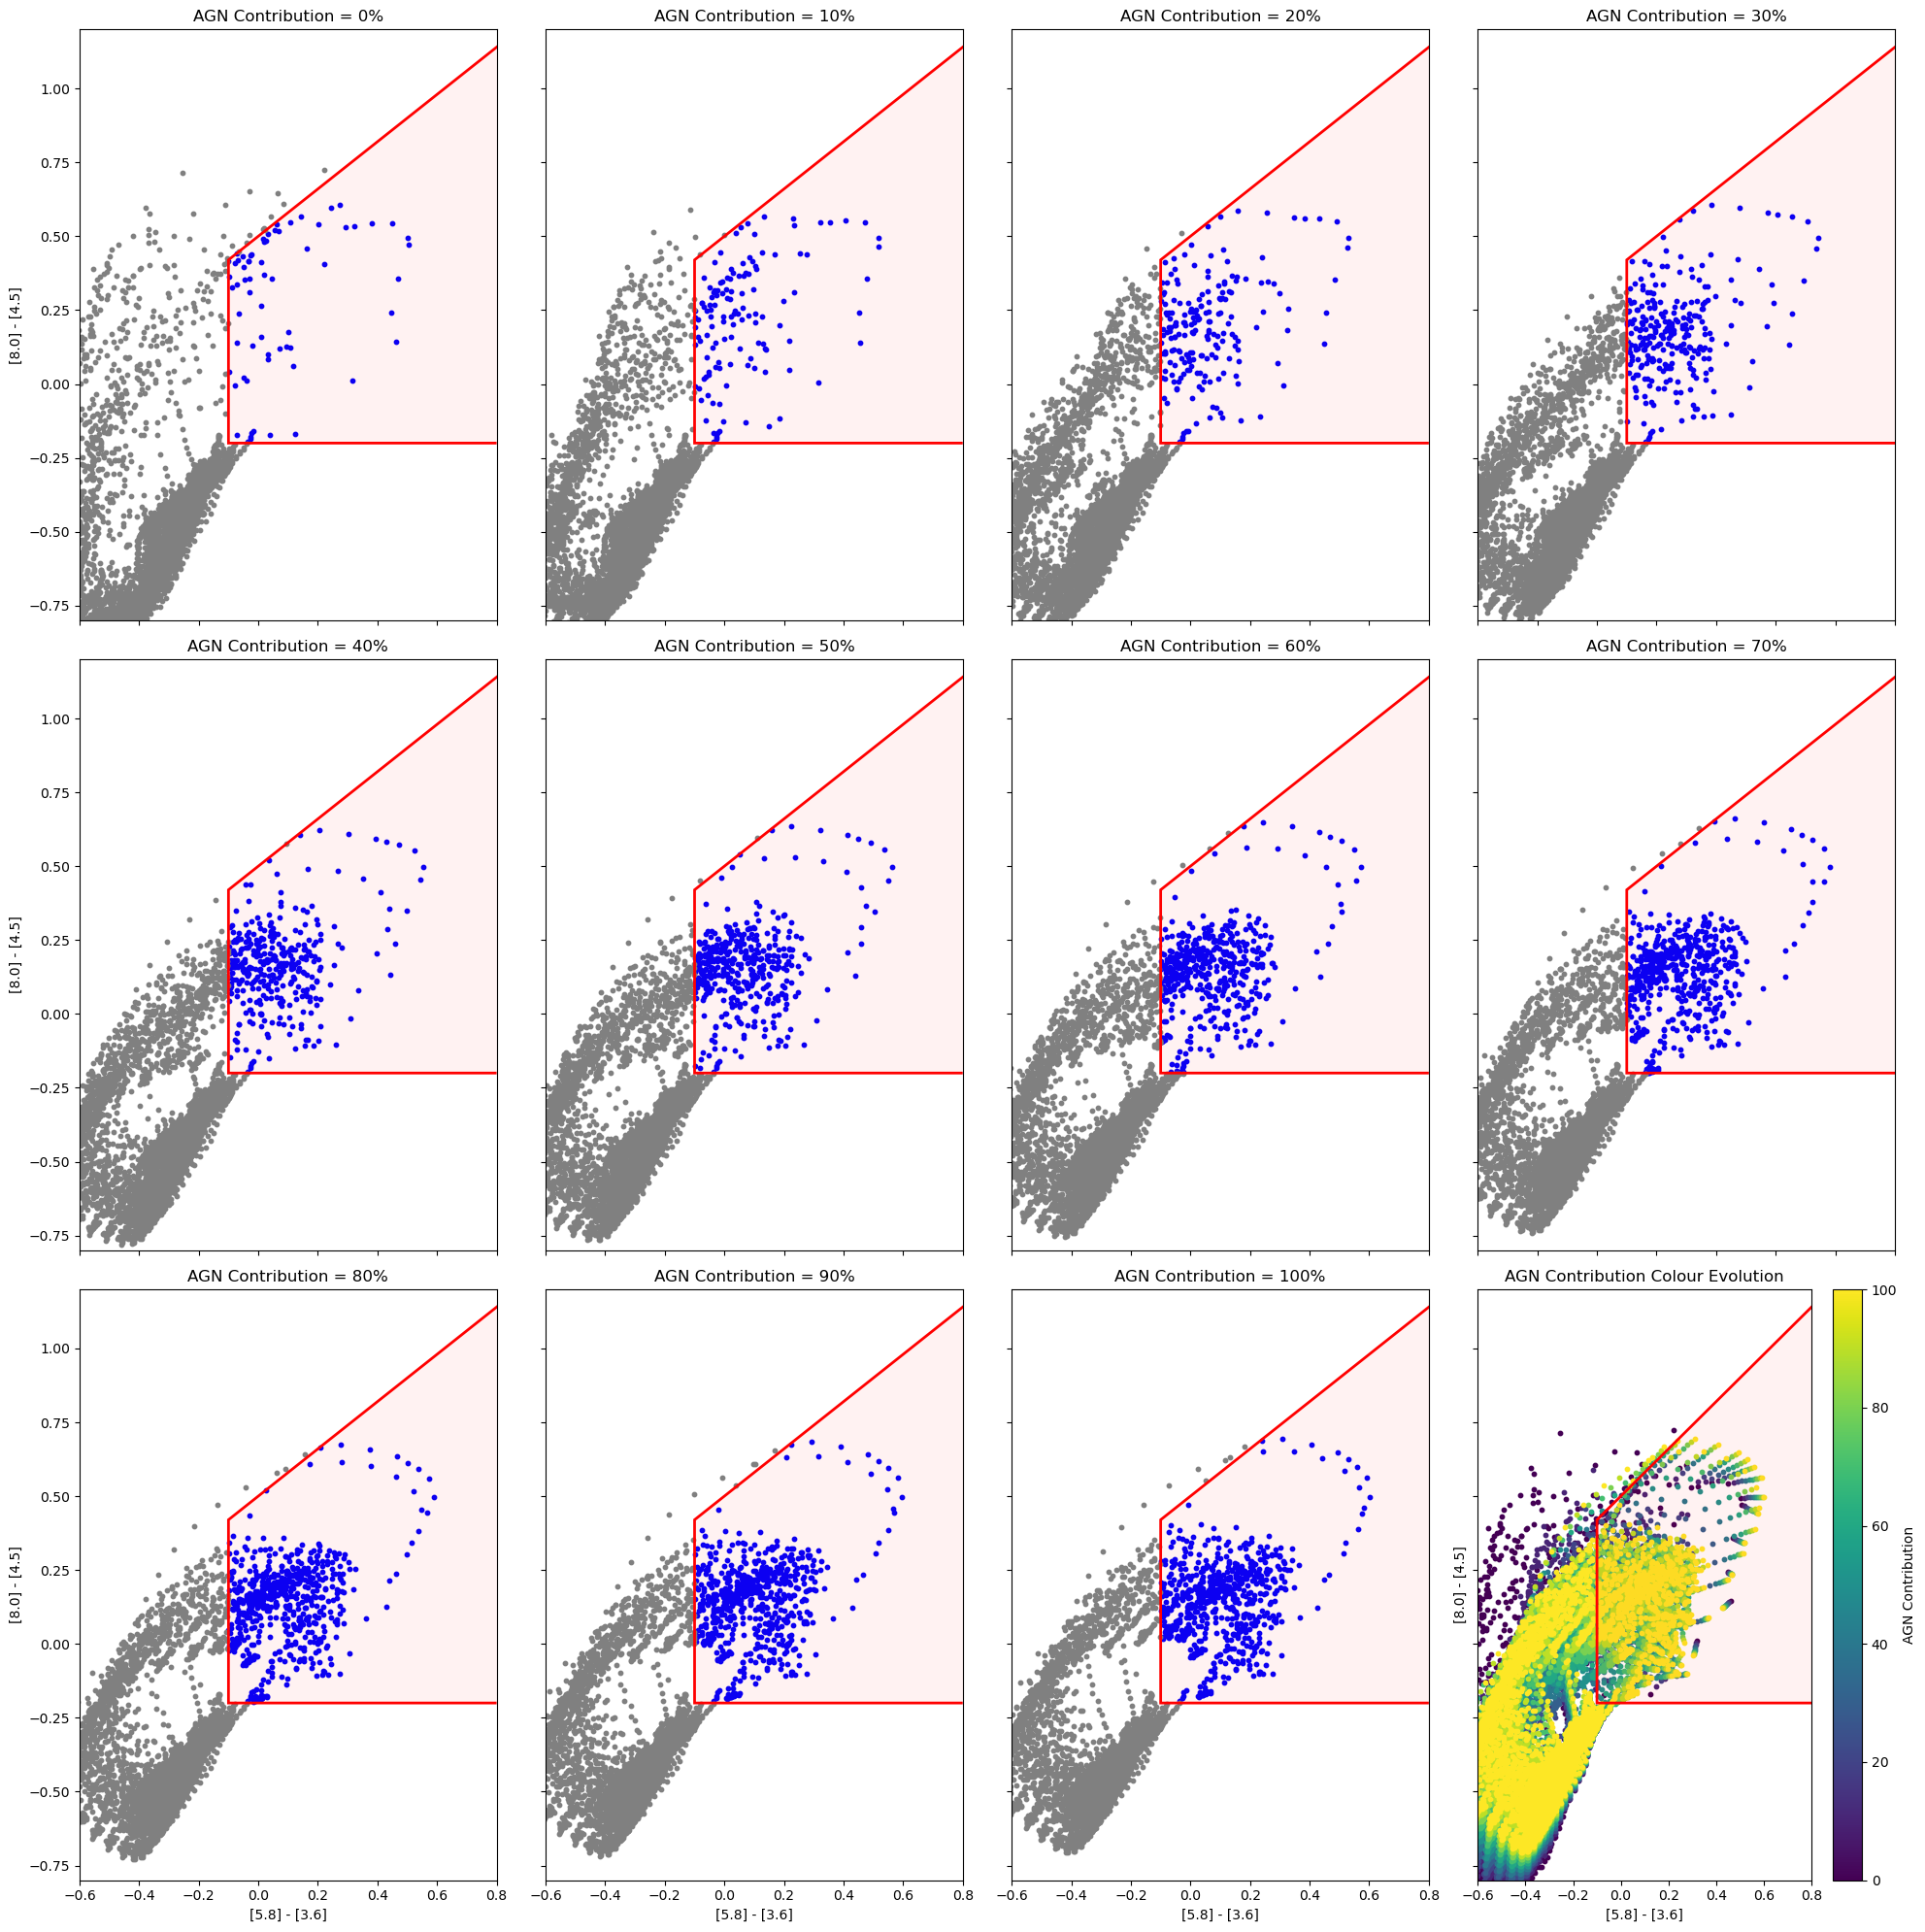

In [226]:
# Choose the diagram min and max
xmax = 0.8
ymax = 1.2
xmin = -0.6
ymin = -0.8



# setup 
fig, axs = plt.subplots(3, 4, figsize=(20, 20), sharex=True, sharey=True)
for n in range(len(alpha_values)):
    
    # Get the IRAC magnitudes
    f_36 = composite_fluxes[f'IRAC3.6_{alpha_values[n]}']
    f_45 = composite_fluxes[f'IRAC4.5_{alpha_values[n]}']
    f_58 = composite_fluxes[f'IRAC5.8_{alpha_values[n]}']
    f_80 = composite_fluxes[f'IRAC8.0_{alpha_values[n]}']
    
    # Create the colours for the IRAC diagram
    f_5836_specific_alpha_colours = np.log10(f_58/f_36)
    f_8045_specific_alpha_colours = np.log10(f_80/f_45)

    # Redefine x and y for the first alpha value to plot the wedge
    x = f_5836_specific_alpha_colours
    y = f_8045_specific_alpha_colours
    
    # Can change this to ensure we are only looking at the rest frame stuff
    x = x[(composite_fluxes['z'] >= 0) & (composite_fluxes['z'] <= 3.9)]
    y = y[(composite_fluxes['z'] >= 0) & (composite_fluxes['z'] <= 3.9)]
    
    
    
    # Reimplement the selection criteria 
    lacy_selection_condition = (x > -0.1) & (y > -0.2) & (y < 0.8 * x + 0.5)
    
    # Colour code for each alpha
    axs[n//4, n%4].scatter(x[lacy_selection_condition], y[lacy_selection_condition], c='blue', s=10)
    axs[n//4, n%4].scatter(x[~lacy_selection_condition], y[~lacy_selection_condition], c='grey', s=10)
    
    
    # Get the IRAC magnitudes
    f_36 = composite_fluxes[f'IRAC3.6_{alpha_values[0]}']
    f_45 = composite_fluxes[f'IRAC4.5_{alpha_values[0]}']
    f_58 = composite_fluxes[f'IRAC5.8_{alpha_values[0]}']
    f_80 = composite_fluxes[f'IRAC8.0_{alpha_values[0]}']
    
    # Create the colours for the IRAC diagram
    f_5836_specific_alpha_colours = np.log10(f_58/f_36)
    f_8045_specific_alpha_colours = np.log10(f_80/f_45)
    
    
    # Redefine x and y for the first alpha value to plot the wedge
    x = f_5836_specific_alpha_colours
    y = f_8045_specific_alpha_colours
    
    # # Ensure we are only looking at the rest frame stuff
    # x = x[composite_fluxes['z'] == 0]
    # y = y[composite_fluxes['z'] == 0]
      # Can change this to ensure we are only looking at the rest frame stuff
    x = x[(composite_fluxes['z'] >= 0) & (composite_fluxes['z'] <= 3.9)]
    y = y[(composite_fluxes['z'] >= 0) & (composite_fluxes['z'] <= 3.9)]
    
    # # Reimplement the selection criteria
    lacy_selection_condition = (x > -0.1) & (y > -0.2) & (y < 0.8 * x + 0.5)
    wedge_vertices = [
        (xmax, -0.2),
        (-0.1, -0.2),
        (-0.1, 0.8*np.nanmin(x[lacy_selection_condition]) + 0.5 if np.any(lacy_selection_condition) else -0.2),  # Handle empty selection
        (((ymax-0.5)/0.8), ymax)
    ] 
    wedge_polygon = plt.Polygon(wedge_vertices, closed=False, edgecolor='r', facecolor=(1,0,0,0.05), linestyle='-', linewidth=2, label='Lacy Wedge')
    # Plot the polygon on the subplot
    axs[n//4, n%4].add_patch(wedge_polygon)
    
    
    # Set the AGN Contribution title
    axs[n//4, n%4].set_title(f"AGN Contribution = {alpha_values[n]}%")
    
    # Set the axis labels
    if n//4 == 2:
        axs[n//4, n%4].set_xlabel("[5.8] - [3.6]")
    if n%4 == 0:
        axs[n//4, n%4].set_ylabel("[8.0] - [4.5]")
    
    # Set the axis limits
    axs[n//4, n%4].set_xlim(xmin, xmax)
    axs[n//4, n%4].set_ylim(ymin, ymax)
    
# We want an AGN evolution plot for
for m in range(len(alpha_values)):
    
    # Get the IRAC magnitudes
    f_36 = composite_fluxes[f'IRAC3.6_{alpha_values[m]}']
    f_45 = composite_fluxes[f'IRAC4.5_{alpha_values[m]}']
    f_58 = composite_fluxes[f'IRAC5.8_{alpha_values[m]}']
    f_80 = composite_fluxes[f'IRAC8.0_{alpha_values[m]}']
    
    # Create the colours for the IRAC diagram
    f_5836_specific_alpha_colours = np.log10(f_58/f_36)
    f_8045_specific_alpha_colours = np.log10(f_80/f_45)
    
    # Redefine x and y for the first alpha value to plot the wedge
    x = f_5836_specific_alpha_colours
    y = f_8045_specific_alpha_colours
    
    # Can change this to ensure we are only looking at the rest frame stuff
    x = x[(composite_fluxes['z'] >= 0) & (composite_fluxes['z'] <= 3.9)]
    y = y[(composite_fluxes['z'] >= 0) & (composite_fluxes['z'] <= 3.9)]
    
    # Reimplement the selection criteria 
    lacy_selection_condition = (x > -0.1) & (y > -0.2) & (y < 0.8 * x + 0.5)
    
    # Colour code for each alpha
    axs[2, 3].scatter(x, y, c=colours_theme[m], s=10)
    
# Get the IRAC magnitudes
f_36 = composite_fluxes[f'IRAC3.6_{alpha_values[0]}']
f_45 = composite_fluxes[f'IRAC4.5_{alpha_values[0]}']
f_58 = composite_fluxes[f'IRAC5.8_{alpha_values[0]}']
f_80 = composite_fluxes[f'IRAC8.0_{alpha_values[0]}']

# Create the colours for the IRAC diagram
f_5836_specific_alpha_colours = np.log10(f_58/f_36)
f_8045_specific_alpha_colours = np.log10(f_80/f_45)

# Redefine x and y for the first alpha value to plot the wedge
x = f_5836_specific_alpha_colours
y = f_8045_specific_alpha_colours

# Can change this to ensure we are only looking at the rest frame stuff
x = x[(composite_fluxes['z'] >= 0) & (composite_fluxes['z'] <= 3.9)]
y = y[(composite_fluxes['z'] >= 0) & (composite_fluxes['z'] <= 3.9)]

# # Reimplement the selection criteria
lacy_selection_condition = (x > -0.1) & (y > -0.2) & (y < 0.8 * x + 0.5)

wedge_vertices = [
    (xmax, -0.2),
    (-0.1, -0.2),
    (-0.1, 0.8*np.nanmin(x[lacy_selection_condition]) + 0.5 if np.any(lacy_selection_condition) else -0.2),  # Handle empty selection
    (((ymax-0.5)/0.8), ymax)
]

axs[2, 3].add_patch(plt.Polygon(wedge_vertices, closed=False, edgecolor='r', facecolor=(1,0,0,0.05), linestyle='-', linewidth=2, label='Lacy Wedge'))

# Set the axis labels
axs[2, 3].set_xlabel("[5.8] - [3.6]")
axs[2, 3].set_ylabel("[8.0] - [4.5]")

# Set the axis limits
axs[2, 3].set_xlim(xmin, xmax)
axs[2, 3].set_ylim(ymin, ymax)

# Add a colorbar for the AGN contribution
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(alpha_values), vmax=max(alpha_values)))
cbar = plt.colorbar(sm, ax=axs[2, 3])

# Add the colorbar label
cbar.set_label('AGN Contribution')

# add the final subplot labels
axs[2, 3].set_title("AGN Contribution Colour Evolution")

    
    
    


# tight 
plt.tight_layout()

# Save the output
if save_figures:
    
    plt.savefig(f'outputs/IRACPlots/IRAC_alpha_{agn_model_name}.png')
    
      
# Show the output
plt.show()

### Metrics